In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [108]:
#https://www.lendingclub.com/info/download-data.action

# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## Blind Approach

In [ ]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=5)

### This kills the kernel

- get_dummies can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier.
-  If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [8]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


- Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. 

In [112]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

- Wonder what was causing the dtype error on the id column, which should have all been integers? Let's look at the end of the file.

In [113]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

- Now this should be better. Let's try again.

In [115]:
pd.get_dummies(y2015).head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0


## Second Attempt

- model takes a few minutes to run

In [184]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anacon

array([0.97919783, 0.98052765, 0.98164375, 0.98164375, 0.95886963,
       0.97876989, 0.9357857 , 0.98076421, 0.98007457, 0.98014535])

- The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.
- There's also some variance in the scores. The fact that one gave us only 94% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

- So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

- You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. 

In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# scale the input into mean 0 and standardized variance
X2 = StandardScaler().fit_transform(X)

#PCA where 95% of variance is retained
pca = PCA(.95)
newX = pca.fit_transform(X2)

print(pca.explained_variance_ratio_)

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


[0.05398192 0.03100909 0.03001029 0.02380855 0.01897304 0.01614858
 0.01581418 0.01469201 0.01319392 0.01289215 0.01170546 0.01126425
 0.01063952 0.01036281 0.01026474 0.01016406 0.01013119 0.0101064
 0.0100784  0.01005639 0.01002898 0.00986733 0.00976003 0.0095064
 0.00891365 0.00833105 0.00808788 0.00763605 0.00754539 0.00740427
 0.00726111 0.00718242 0.00708062 0.00702475 0.00691971 0.00689686
 0.00683314 0.00679215 0.0066887  0.00666134 0.00657991 0.00652806
 0.00649043 0.00642359 0.00637718 0.00633678 0.00627065 0.00625026
 0.00618573 0.00611503 0.00599629 0.00595965 0.0058827  0.00585341
 0.00582336 0.00581389 0.00579156 0.00567338 0.00564903 0.00559327
 0.00553792 0.00550659 0.00549099 0.00545239 0.00544201 0.00542666
 0.00538995 0.00537795 0.00536071 0.00532375 0.00532318 0.00531119
 0.00529623 0.00527301 0.00525788 0.00524812 0.00524185 0.00521922
 0.0051763  0.00516835 0.00512905 0.00508192 0.00507077 0.00505929
 0.00502618 0.00502548 0.00502527 0.00502456 0.00502405 0.005023

In [ ]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, newX, Y, cv=10)

In [116]:
total_missing = y2015.isnull().sum().sort_values(ascending=False) 
                                                    #take a count of missing values and their corresponding columns

percent_missing = (y2015.isnull().sum()/y2015.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(36)

,Total,Percent
dti_joint,420586,0.998791
annual_inc_joint,420584,0.998786
verification_status_joint,420584,0.998786
il_util,402478,0.955789
mths_since_rcnt_il,400285,0.950581
open_acc_6m,399723,0.949247
inq_last_12m,399723,0.949247
total_cu_tl,399723,0.949247
inq_fi,399723,0.949247
all_util,399723,0.949247


In [29]:
non_numeric_columns = y2015.select_dtypes(['object']).columns #select non-numeric columns for review
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type', 'verification_status_joint'],
      dtype='object')
The number of non-numerical columns is 16


In [203]:
df = y2015.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 103 entries, id to total_il_high_credit_limit
dtypes: float64(87), object(16)
memory usage: 330.9+ MB


In [204]:
total_missing = df.select_dtypes(include=['float64','int']).isnull().sum().sort_values(ascending=False) 
                    #find the total null data values in each column based on percentage of data points in each column 

percent_missing = (df.select_dtypes(include=['float64','int']).isnull().sum()/df.select_dtypes(include=['float64','int']).isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(30)

,Total,Percent
dti_joint,420586,0.998791
annual_inc_joint,420584,0.998786
il_util,402478,0.955789
mths_since_rcnt_il,400285,0.950581
open_acc_6m,399723,0.949247
open_il_6m,399723,0.949247
open_il_12m,399723,0.949247
open_il_24m,399723,0.949247
total_bal_il,399723,0.949247
open_rv_12m,399723,0.949247


In [205]:
fill_list = ['dti_joint','annual_inc_joint','il_util','mths_since_rcnt_il','open_acc_6m','open_il_6m','open_il_12m',
'open_il_24m','total_bal_il','open_rv_12m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m',
'open_rv_24m','mths_since_last_record','mths_since_recent_bc_dlq','mths_since_last_major_derog',
 'mths_since_recent_revol_delinq','mths_since_last_delinq','mths_since_recent_inq','num_tl_120dpd_2m',
 'mo_sin_old_il_acct','percent_bc_gt_75','bc_util','bc_open_to_buy','mths_since_recent_bc','num_rev_accts']


In [206]:
for col in fill_list: #fill missing values by interpolation method
    df.loc[:, col].interpolate(inplace=True) 

In [208]:
total_missing = df.select_dtypes(include=['float64','int']).isnull().sum().sort_values(ascending=False) 
                    #find the total null data values in each column based on percentage of data points in each column 

percent_missing = (df.select_dtypes(include=['float64','int']).isnull().sum()/df.select_dtypes(include=['float64','int']).isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(3)

,Total,Percent
dti_joint,10,0.000024
annual_inc_joint,10,0.000024
total_il_high_credit_limit,0,0.000000


## Importance Analysis
- analyze the most influential features of the data to reduce our random forest classifier

In [210]:
X = df.drop('loan_status', 1)
Y = df['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

rfc_model = rfc.fit(X, Y)
rfc_model.feature_importances_

sorted_feature_importance = sorted(zip(rfc_model.feature_importances_, list(X)), reverse=True)

In [211]:
sorted_feature_importance_top_10 = sorted_feature_importance[0:10]
sorted_feature_importance_top_10 = [x[1] for x in sorted_feature_importance_top_10]
sorted_feature_importance_top_10

['out_prncp',
 'last_pymnt_d_Jan-2017',
 'out_prncp_inv',
 'last_pymnt_amnt',
 'last_credit_pull_d_Jan-2017',
 'total_pymnt',
 'next_pymnt_d_Feb-2017',
 'total_rec_prncp',
 'total_pymnt_inv',
 'last_pymnt_d_Dec-2016']

Feature ranking:
1. feature 15 (0.180392)
2. feature 24 (0.144427)
3. feature 16 (0.111048)
4. feature 166 (0.097802)
5. feature 151 (0.075870)
6. feature 18 (0.042837)
7. feature 17 (0.039699)
8. feature 181 (0.039182)
9. feature 19 (0.019972)
10. feature 22 (0.016134)
11. feature 165 (0.015357)
12. feature 161 (0.015137)
13. feature 20 (0.014468)
14. feature 6 (0.014291)
15. feature 193 (0.014069)
16. feature 146 (0.011664)
17. feature 163 (0.011113)
18. feature 23 (0.009723)
19. feature 167 (0.009226)
20. feature 2 (0.008123)
21. feature 3 (0.007857)
22. feature 4 (0.004679)
23. feature 148 (0.004365)
24. feature 0 (0.004196)
25. feature 144 (0.003775)
26. feature 5 (0.003242)
27. feature 21 (0.003045)
28. feature 1 (0.002683)
29. feature 142 (0.002654)
30. feature 59 (0.002437)
31. feature 13 (0.002191)
32. feature 8 (0.002142)
33. feature 30 (0.002134)
34. feature 56 (0.002041)
35. feature 35 (0.002029)
36. feature 7 (0.001984)
37. feature 54 (0.001980)
38. feature 32 (0.001970)
3

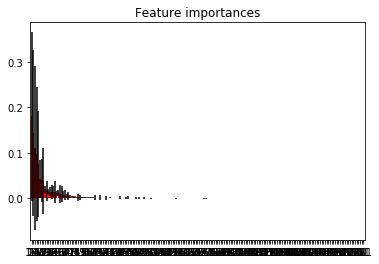

In [192]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 10 variables
- select the top 10 most important features and assess their predictive accuracy.

In [212]:
sorted_feature_importance_top_10.append('loan_status')
df_top_10_variables = df.loc[:, sorted_feature_importance_top_10]

df_top_10_variables.head()


/Users/coreycoole/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,out_prncp,last_pymnt_d_Jan-2017,out_prncp_inv,last_pymnt_amnt,last_credit_pull_d_Jan-2017,total_pymnt,next_pymnt_d_Feb-2017,total_rec_prncp,total_pymnt_inv,last_pymnt_d_Dec-2016,loan_status
0,13668.88,NaN,13668.88,379.39,NaN,4519.68,NaN,2331.12,4519.68,NaN,Current
1,6635.69,NaN,6635.69,298.58,NaN,3572.97,NaN,2964.31,3572.97,NaN,Current
2,0.00,NaN,0.00,20807.39,NaN,26224.23,NaN,25000.00,26224.23,NaN,Fully Paid
3,19263.77,NaN,19263.77,858.05,NaN,10271.36,NaN,8736.23,10271.36,NaN,Current
4,0.00,NaN,0.00,8251.42,NaN,9190.49,NaN,8650.00,9190.49,NaN,Fully Paid


In [214]:
#test by keeping top 10 most important variables
rfc = ensemble.RandomForestClassifier()

X = df_top_10_variables.drop('loan_status', 1)
Y = df_top_10_variables['loan_status']

X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10).mean()

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anacon

0.9280191123029459

- 92% is above out 90% threshold, but can we reduce our classifier further?

## only 3 variables
- here we choose the top 4 features, using 3 of them since one is found to be NA data.

In [233]:
sorted_feature_importance_top_4 = sorted_feature_importance[0:4]
sorted_feature_importance_top_4 = [x[1] for x in sorted_feature_importance_top_4]
sorted_feature_importance_top_4

['out_prncp', 'last_pymnt_d_Jan-2017', 'out_prncp_inv', 'last_pymnt_amnt']

In [234]:
sorted_feature_importance_top_4.append('loan_status')
df_top_4_variables = df.loc[:, sorted_feature_importance_top_4]

df_top_4_variables.head()

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,out_prncp,last_pymnt_d_Jan-2017,out_prncp_inv,last_pymnt_amnt,loan_status
0,13668.88,NaN,13668.88,379.39,Current
1,6635.69,NaN,6635.69,298.58,Current
2,0.00,NaN,0.00,20807.39,Fully Paid
3,19263.77,NaN,19263.77,858.05,Current
4,0.00,NaN,0.00,8251.42,Fully Paid


In [235]:
#test by keeping top 4 most important variables
rfc = ensemble.RandomForestClassifier()

X = df_top_4_variables.drop('loan_status', 1)
Y = df_top_4_variables['loan_status']

X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10).mean()

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anacon

0.9252166545832712

- Suprisingly we see this extremly reduced model's predictive power stays above the 90% mark. Lets see if taking the least important feature out of this classifier is too much a change.

## only 2 variables

In [245]:
sorted_feature_importance_top_3 = sorted_feature_importance[0:3]
sorted_feature_importance_top_3 = [x[1] for x in sorted_feature_importance_top_3]
sorted_feature_importance_top_3

['out_prncp', 'last_pymnt_d_Jan-2017', 'out_prncp_inv']

In [246]:
sorted_feature_importance_top_3.append('loan_status')
df_top_3_variables = df.loc[:, sorted_feature_importance_top_3]

df_top_3_variables.head()

,out_prncp,last_pymnt_d_Jan-2017,out_prncp_inv,loan_status
0,13668.88,NaN,13668.88,Current
1,6635.69,NaN,6635.69,Current
2,0.00,NaN,0.00,Fully Paid
3,19263.77,NaN,19263.77,Current
4,0.00,NaN,0.00,Fully Paid


In [247]:
#test by keeping top 2 most important variables
rfc = ensemble.RandomForestClassifier()

X = df_top_3_variables.drop('loan_status', 1)
Y = df_top_3_variables['loan_status']

X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10).mean()

/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/coreycoole/anacon

0.8597940280216847

- Here we see that the classifier model has dropped below 90% in predicitive accuracy with only 2 features.
- Thusly we can say that the most reduced classifier in this way, is one that contains the 3 most important features.

### Can you do it without using anything related to payment amount or outstanding principal? How do you know?

- In this method of feature section based on importance, it does not look like we could achieve this reduced classifier without using anything related to payment amount or outstanding principle since nine out of the top ten most important features all cover this type of data.